Higgs Boson Dataset, source - UCI - https://archive.ics.uci.edu/dataset/280/higgs  
This is a classification problem to distinguish between a signal process which produces Higgs bosons and a background process which does not.  
[In simple terms identifying if that's a higgs boson particle or just a random background noise]

In [1]:
#Import all the necessary dependencies
import openml
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
#Get the data from openml with respective id
dataset= openml.datasets.get_dataset(42769)
df, *_ = dataset.get_data()

df.head()

target  lepton_pT  lepton_eta  lepton_phi  missing_energy_magnitude  \
0      0   1.334136   -0.948700   -1.153246                  0.801749   
1      0   0.826652    1.318700   -0.395858                  0.580982   
2      0   2.085572   -0.923377    0.251769                  1.431479   
3      0   1.242083    0.482060    1.010819                  0.648965   
4      0   0.456242   -1.420101    0.641836                  1.373543   

   missing_energy_phi  jet_1_pt  jet_1_eta  jet_1_phi  jet_1_b-tag  ...  \
0            0.941352  0.311831   0.417852   0.762981          0.0  ...   
1            1.441384  0.945112  -1.875521  -1.476246          0.0  ...   
2            0.565579  1.836358  -0.548613   1.632796          0.0  ...   
3           -1.061120  0.431287  -2.477581   0.250739          0.0  ...   
4            1.550892  1.002916  -0.956588  -0.309283          0.0  ...   

   jet_4_eta  jet_4_phi  jet_4_b-tag      m_jj     m_jjj      m_lv     m_jlv  \
0   1.989154   0.174081     0.000000  0.932257  0.913944  1.361426  1.068599   
1  -1.522862  -0.827641     0.000000  0.695305  0.939961  0.987348  0.789509   
2  -0.352745  -0.206137     3.101961  2.906047  1.819818  0.987667  0.816174   
3   1.152999   0.054775     3.101961  4.006865  2.246852  1.189937  0.749284   
4  -1.955097  -0.400356     0.000000  0.781153  0.900710  0.987214  0.882362   

       m_bb     m_wbb    m_wwbb  
0  0.895866  1.069050  1.062432  
1  0.837691  1.625991  1.448658  
2  0.382939  1.292237  1.347594  
3  0.993789  1.531145  1.281588  
4  1.276041  0.963040  0.890228  

[5 rows x 29 columns]

In [3]:
#Info of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 29 columns):
 #   Column                    Non-Null Count    Dtype   
---  ------                    --------------    -----   
 0   target                    1000000 non-null  category
 1   lepton_pT                 1000000 non-null  float64 
 2   lepton_eta                1000000 non-null  float64 
 3   lepton_phi                1000000 non-null  float64 
 4   missing_energy_magnitude  1000000 non-null  float64 
 5   missing_energy_phi        1000000 non-null  float64 
 6   jet_1_pt                  1000000 non-null  float64 
 7   jet_1_eta                 1000000 non-null  float64 
 8   jet_1_phi                 1000000 non-null  float64 
 9   jet_1_b-tag               1000000 non-null  float64 
 10  jet_2_pt                  1000000 non-null  float64 
 11  jet_2_eta                 1000000 non-null  float64 
 12  jet_2_phi                 1000000 non-null  float64 
 13  jet_2_b-tag  

In [4]:
#Understand every different feature and it's diversity
df.describe()

lepton_pT      lepton_eta      lepton_phi  \
count  1000000.000000  1000000.000000  1000000.000000   
mean         0.991937        0.000511       -0.000090   
std          0.565721        1.008497        1.007074   
min          0.274697       -2.434976       -1.742508   
25%          0.590753       -0.738322       -0.873595   
50%          0.853371        0.000920        0.002081   
75%          1.236776        0.738214        0.872659   
max          9.745601        2.434868        1.743236   

       missing_energy_magnitude  missing_energy_phi        jet_1_pt  \
count            1000000.000000      1000000.000000  1000000.000000   
mean                   0.998829           -0.000903        0.990856   
std                    0.600386            1.006370        0.474761   
min                    0.001232           -1.743938        0.138235   
25%                    0.577381           -0.872690        0.679542   
50%                    0.891748           -0.001139        0.894819   
75%                    1.292865            0.870579        1.170557   
max                    9.900929            1.743246        8.382610   

            jet_1_eta       jet_1_phi     jet_1_b-tag        jet_2_pt  ...  \
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000  ...   
mean        -0.000038       -0.000472        0.999892        0.992398  ...   
std          1.008807        1.005382        1.027669        0.500392  ...   
min         -2.969725       -1.741237        0.000000        0.188981  ...   
25%         -0.686255       -0.868096        0.000000        0.656083  ...   
50%         -0.001016       -0.000496        1.086538        0.889256  ...   
75%          0.687194        0.866095        2.173076        1.202001  ...   
max          2.969674        1.741454        2.173076       11.647081  ...   

            jet_4_eta       jet_4_phi     jet_4_b-tag            m_jj  \
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
mean         0.000286        0.000202        0.998675        1.034557   
std          1.008676        1.006354        1.399993        0.675292   
min         -2.497265       -1.742691        0.000000        0.091766   
25%         -0.714190       -0.870924        0.000000        0.790429   
50%          0.001205       -0.000264        0.000000        0.895047   
75%          0.714934        0.872160        3.101961        1.024910   
max          2.498009        1.743372        3.101961       40.192368   

                m_jjj            m_lv           m_jlv            m_bb  \
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
mean         1.024504        1.050537        1.009503        0.973548   
std          0.380350        0.164689        0.397131        0.525562   
min          0.264307        0.145206        0.132006        0.052252   
25%          0.846288        0.985749        0.767548        0.674177   
50%          0.950613        0.989774        0.916580        0.873692   
75%          1.083211        1.020462        1.141467        1.139971   
max         20.372782        7.992739       11.906574       12.628461   

                m_wbb          m_wwbb  
count  1000000.000000  1000000.000000  
mean         1.033132        0.960056  
std          0.364692        0.313233  
min          0.295112        0.363718  
25%          0.819872        0.770585  
50%          0.947731        0.872414  
75%          1.140720        1.059388  
max         11.496522        8.374498  

[8 rows x 28 columns]

In [5]:
#Check for null values
df.isna().sum()

target                      0
lepton_pT                   0
lepton_eta                  0
lepton_phi                  0
missing_energy_magnitude    0
missing_energy_phi          0
jet_1_pt                    0
jet_1_eta                   0
jet_1_phi                   0
jet_1_b-tag                 0
jet_2_pt                    0
jet_2_eta                   0
jet_2_phi                   0
jet_2_b-tag                 0
jet_3_pt                    0
jet_3_eta                   0
jet_3_phi                   0
jet_3_b-tag                 0
jet_4_pt                    0
jet_4_eta                   0
jet_4_phi                   0
jet_4_b-tag                 0
m_jj                        0
m_jjj                       0
m_lv                        0
m_jlv                       0
m_bb                        0
m_wbb                       0
m_wwbb                      0
dtype: int64

In [6]:
#Check count of both target labels
df['target'].value_counts()

target
1    529920
0    470080
Name: count, dtype: int64

<Axes: >

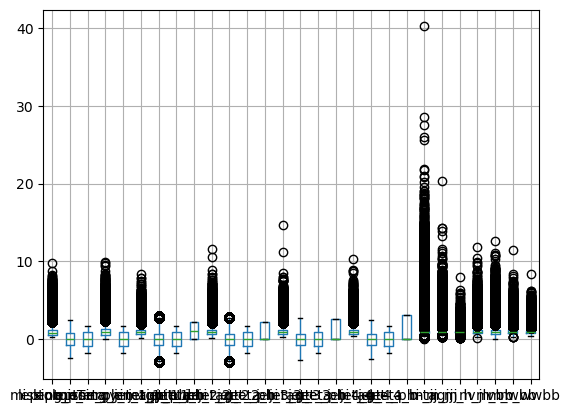

In [7]:
#Boxplot to visualize if any outliers
df.boxplot()

In [8]:

num_cols = df.select_dtypes(include=np.number).columns.tolist()

In [9]:

df['target']= pd.to_numeric(df['target'], errors='coerce')

In [10]:
#Split data into features and target; X and y
X = df.drop('target', axis=1)
y = df['target']
type(y)

pandas.core.series.Series

In [11]:
#Split train and test data with 70, 30 ratio
xtrain, xtest, ytrain,ytest = train_test_split(X,y, test_size=0.30, random_state=42)
print(ytrain.shape) 
print(ytest.shape)

(700000,)
(300000,)


In [12]:
#Create a lgb dataset
train_data = lgb.Dataset(xtrain, label= ytrain)
test_data = lgb.Dataset(xtest,label=ytest, reference=train_data)

In [13]:
#Initialise params
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_extraction': 0.9
}

In [14]:
#Train the model
num_round = 100
early_stopping_rounds = 10

callbacks = [lgb.early_stopping(stopping_rounds=early_stopping_rounds)]

lgbmodel = lgb.train(params, train_data, num_round, valid_sets=[test_data],callbacks=callbacks)

[LightGBM] [Warning] Unknown parameter: feature_extraction
[LightGBM] [Warning] Unknown parameter: feature_extraction
[LightGBM] [Info] Number of positive: 370792, number of negative: 329208
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6132
[LightGBM] [Info] Number of data points in the train set: 700000, number of used features: 28
[LightGBM] [Warning] Unknown parameter: feature_extraction
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.529703 -> initscore=0.118951
[LightGBM] [Info] Start training from score 0.118951
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_error: 0.27677


In [15]:
#Predict model using test data
ypred = lgbmodel.predict(xtest, num_iteration=lgbmodel.best_iteration)

In [16]:
#Since this is a binary classification problem, you can convert the probability to class labels (0 or 1)

#Evaluate metrics
ypred_binary = (ypred > 0.5).astype(int)
print(f"Accuracy: {accuracy_score(ytest,ypred_binary)}")
print("Confusion Matrix:\n", confusion_matrix(ytest, ypred_binary))
print("Classfication Report:\n",classification_report(ytest,ypred_binary))

Accuracy: 0.72323
Confusion Matrix:
 [[ 99330  41542]
 [ 41489 117639]]
Classfication Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71    140872
           1       0.74      0.74      0.74    159128

    accuracy                           0.72    300000
   macro avg       0.72      0.72      0.72    300000
weighted avg       0.72      0.72      0.72    300000



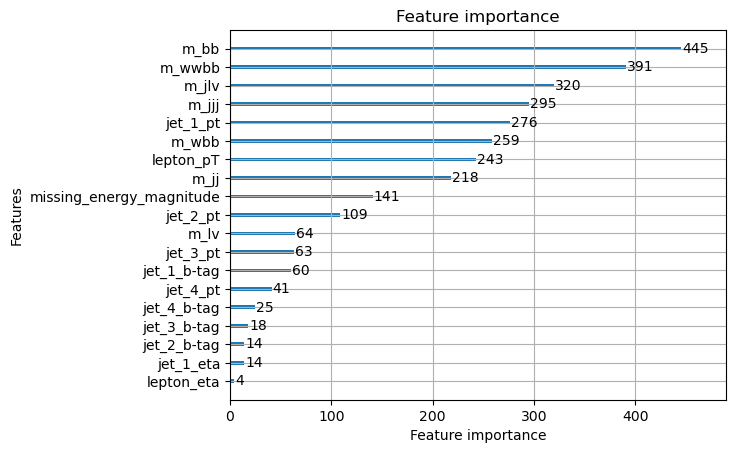

In [20]:
#Feature importance plot
lgb.plot_importance(lgbmodel, importance_type='split',max_num_features=20)
plt.show()

In [22]:
#Print number of trees
print(lgbmodel)
print(lgbmodel.num_trees()) # Should be > 0 if the model is trained


100


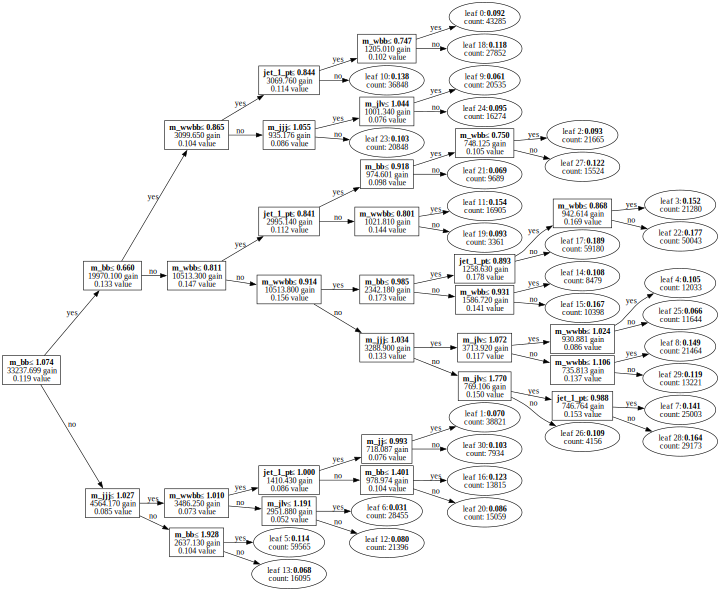

In [29]:
#Plotting the tree plot 
import lightgbm as lgb
import graphviz
from IPython.display import display

graph = lgb.create_tree_digraph(lgbmodel, tree_index=0, show_info=['split_gain', 'internal_value', 'leaf_count'])

if graph:
    graph.attr(size="10,10")  # Set attributes
    display(graph)  # Display the graph
else:
    print("Graph generation failed. Check your Graphviz installation.")


In [33]:
#Inspect all features importances to remove unncessary ones
feature_importance = pd.DataFrame({'Feature': lgbmodel.feature_name(),
                                   'Importance': lgbmodel.feature_importance()})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)

                     Feature  Importance
25                      m_bb         445
27                    m_wwbb         391
24                     m_jlv         320
22                     m_jjj         295
5                   jet_1_pt         276
26                     m_wbb         259
0                  lepton_pT         243
21                      m_jj         218
3   missing_energy_magnitude         141
9                   jet_2_pt         109
23                      m_lv          64
13                  jet_3_pt          63
8                jet_1_b-tag          60
17                  jet_4_pt          41
20               jet_4_b-tag          25
16               jet_3_b-tag          18
12               jet_2_b-tag          14
6                  jet_1_eta          14
1                 lepton_eta           4
2                 lepton_phi           0
4         missing_energy_phi           0
7                  jet_1_phi           0
19                 jet_4_phi           0
18              

In [36]:
#Dropping Low importance features to improve model performance
low_impfeatures = [
    'lepton_phi','missing_energy_phi','jet_1_phi','jet_4_phi','jet_4_eta','jet_3_phi','jet_2_phi','jet_2_eta','jet_3_eta'
]

Xnew = X.drop(columns=low_impfeatures)

#Split and train data according to New X features
xtrain, xtest,ytrain, ytest = train_test_split(Xnew,y,test_size=0.3, random_state= 42)

print(f"Training set shape: {xtrain.shape}")
print(f"Testing set shape: {xtest.shape}")

#Training Lightgbm model on reduced dataset
train_datanew = lgb.Dataset(xtrain, label=ytrain)
test_datanew = lgb.Dataset(xtest, label=ytest,reference=train_data)

lgbmodel_new  = lgb.train(params, train_datanew, num_round, valid_sets=[test_datanew],callbacks=callbacks)

#Predict and evaluate
ypred_n = lgbmodel_new.predict(xtest, num_iteration=lgbmodel_new.best_iteration)
ypred_binary_n = (ypred_n > 0.5).astype(int)

# Print results
print(f"Accuracy: {accuracy_score(ytest, ypred_binary_n)}")
print("Confusion Matrix:\n", confusion_matrix(ytest, ypred_binary_n))
print("Classification Report:\n", classification_report(ytest, ypred_binary_n))

Training set shape: (700000, 19)
Testing set shape: (300000, 19)
[LightGBM] [Warning] Unknown parameter: feature_extraction
[LightGBM] [Warning] Unknown parameter: feature_extraction
[LightGBM] [Info] Number of positive: 370792, number of negative: 329208
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3837
[LightGBM] [Info] Number of data points in the train set: 700000, number of used features: 19
[LightGBM] [Warning] Unknown parameter: feature_extraction
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.529703 -> initscore=0.118951
[LightGBM] [Info] Start training from score 0.118951
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_error: 0.27677
Accuracy: 0.72323
Confusion Matrix:
 [[ 99330  41542

Improving model using Hyperparameter tuning

In [46]:
#RandomizedSearchCV hyperparamter tuning
from sklearn.model_selection import RandomizedSearchCV

# Reduce search space but keep strong hyperparameters
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [31, 50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_child_samples': [20, 30, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
# LightGBM model
lgbmodel_new = lgb.LGBMClassifier(objective='binary', metric='binary_error', n_estimators=500)

# Use RandomizedSearchCV 
random_search = RandomizedSearchCV(
    lgbmodel_new, param_distributions=param_dist,
    n_iter=200,  # Sample only 200 random combinations
    cv=3,  # Use 3-fold CV instead of 5-fold
    n_jobs=-1,  # Use all CPU cores for parallel training
    verbose=1, 
    scoring='accuracy',
    random_state=42
)

# Reduce training data size for search (use 200k instead of full 700k)
X_sample, _, y_sample, _ = train_test_split(xtrain, ytrain, train_size=200000, random_state=42)

# Fit with early stopping
random_search.fit(X_sample, y_sample)

# Get best model
bestmodel = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# Train final model on full dataset
bestmodel.fit(xtrain, ytrain, eval_set=[(xtest, ytest)],
              eval_metric="logloss",  # LightGBM expects eval_metric
              callbacks=[lgb.early_stopping(10), lgb.log_evaluation(100)]  # LightGBM-style early stopping,
              )

# Predict & evaluate
ypred_n2 = bestmodel.predict(xtest)
ypred_binary_n2 = (ypred_n2 > 0.5).astype(int)

print(f"Accuracy: {accuracy_score(ytest, ypred_binary_n2)}")
print("Confusion Matrix:\n", confusion_matrix(ytest, ypred_binary_n2))
print("Classification Report:\n", classification_report(ytest, ypred_binary_n2))


Fitting 3 folds for each of 200 candidates, totalling 600 fits
[LightGBM] [Info] Number of positive: 70793, number of negative: 62540
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3837
[LightGBM] [Info] Number of data points in the train set: 133333, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.530949 -> initscore=0.123954
[LightGBM] [Info] Start training from score 0.123954
[LightGBM] [Info] Number of positive: 70794, number of negative: 62540
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3837
[LightGBM] [Info] Number of data points in the tr